In [1]:
!pip install tf-keras transformers tensorflow statsmodels seaborn scikit-learn > null

In [2]:
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
articles_name = 'green_energy_articles_max_articles_end20220101'
articles_df = pd.read_csv(f'datasets/{articles_name}.csv')
articles_df['Time'] = pd.to_datetime(articles_df['Time'], format='%d %b, %Y, %I:%M %p IST')
# Convert the 'Time' column in articles_df to datetime
articles_df['Date'] = pd.to_datetime(articles_df['Time'], format='%d %b, %Y, %I:%M %p IST').dt.date


print(f'Number of articles: {articles_df.shape[0]}')
articles_df.head()

Number of articles: 1254


,Title,Link,Description,Time,Date
0,"NexGen Energia plans to invest Rs 15,000 cr ov...",https://economictimes.indiatimes.com/industry/...,"NexGen Energia plans a Rs 15,000 crore investm...",2024-07-07 13:52:00,2024-07-07
1,JSW Energy plans ₹1.15 L cr capex to diversify...,https://economictimes.indiatimes.com/industry/...,JSW Energy announces a strategic shift towards...,2024-07-06 00:35:00,2024-07-06
2,Interest subvention likely to push energy effi...,https://economictimes.indiatimes.com/industry/...,The power ministry has begun discussions on of...,2024-07-05 23:45:00,2024-07-05
3,MNRE issues incentive guidelines for green hyd...,https://economictimes.indiatimes.com/industry/...,Solar Energy Corporation of India (SECI) is th...,2024-07-05 17:29:00,2024-07-05
4,Norms issued for funding of testing facilities...,https://economictimes.indiatimes.com/industry/...,The Ministry of New and Renewable Energy has r...,2024-07-05 00:41:00,2024-07-05


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load a pre-trained financial sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return predictions.numpy()[0] # [Positive, Negative, Neutral]

# Apply sentiment analysis to each article
articles_df['Sentiment'] = articles_df['Title'].apply(get_sentiment_score)
articles_df.head()

,Title,Link,Description,Time,Date,Sentiment
0,"NexGen Energia plans to invest Rs 15,000 cr ov...",https://economictimes.indiatimes.com/industry/...,"NexGen Energia plans a Rs 15,000 crore investm...",2024-07-07 13:52:00,2024-07-07,"[0.41640264, 0.0076391115, 0.57595825]"
1,JSW Energy plans ₹1.15 L cr capex to diversify...,https://economictimes.indiatimes.com/industry/...,JSW Energy announces a strategic shift towards...,2024-07-06 00:35:00,2024-07-06,"[0.77845913, 0.0070157633, 0.21452509]"
2,Interest subvention likely to push energy effi...,https://economictimes.indiatimes.com/industry/...,The power ministry has begun discussions on of...,2024-07-05 23:45:00,2024-07-05,"[0.9494296, 0.025358075, 0.025212333]"
3,MNRE issues incentive guidelines for green hyd...,https://economictimes.indiatimes.com/industry/...,Solar Energy Corporation of India (SECI) is th...,2024-07-05 17:29:00,2024-07-05,"[0.17088601, 0.008663609, 0.82045037]"
4,Norms issued for funding of testing facilities...,https://economictimes.indiatimes.com/industry/...,The Ministry of New and Renewable Energy has r...,2024-07-05 00:41:00,2024-07-05,"[0.36596587, 0.008656737, 0.6253774]"


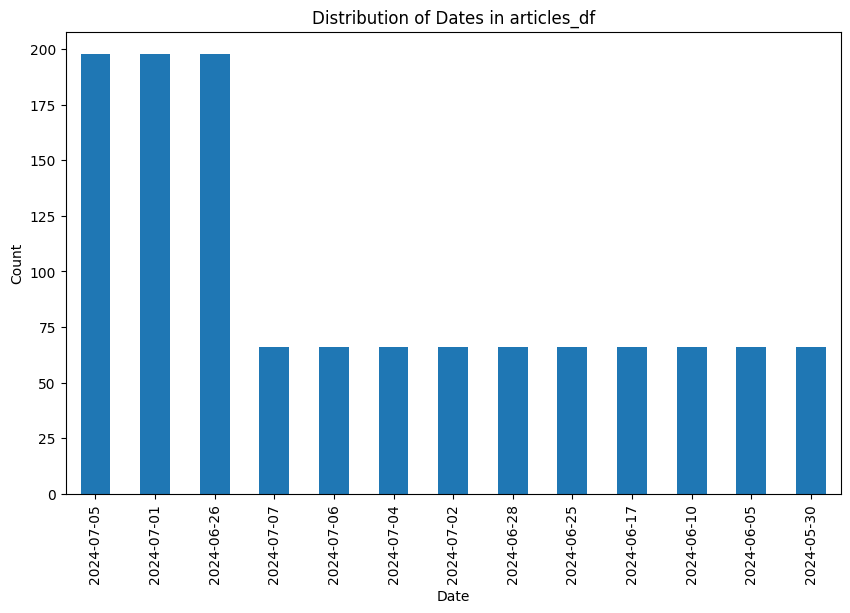

In [5]:
import matplotlib.pyplot as plt

# Count the occurrences of each date
date_counts = articles_df['Date'].value_counts()

# Plot the distribution of dates
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Dates in articles_df')
plt.show()

## Stock Data

In [109]:
import pandas as pd
import numpy as np

product_name = 'ICLN'
prices_df = pd.read_csv(f'datasets/{product_name}.csv')

print(f'Number of rows: {prices_df.shape[0]}')
print(f'Missing values: {prices_df["Close"].isnull().sum()}')


# Convert the 'Date' column in prices_df to datetime
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date


# Set 'Date' as the index
prices_df.set_index('Date', inplace=True)

# Reindex to business days to fill missing dates
business_days = pd.bdate_range(start=prices_df.index.min(), end=prices_df.index.max())
prices_df = prices_df.reindex(business_days)

# Fill missing values (e.g., forward fill)
prices_df = prices_df.ffill()

# Calculate the daily price difference and log of the closing price
prices_df['Close_diff'] = prices_df['Close'].pct_change()
prices_df['Close_log'] = np.log(prices_df.Close)

print(f'first date: {prices_df.index.min()}')
print(f'last date: {prices_df.index.max()}')

prices_df.head()

Number of rows: 4035
Missing values: 0
first date: 2008-06-25 00:00:00
last date: 2024-07-08 00:00:00


,Open,High,Low,Close,Adj Close,Volume,Close_diff,Close_log
2008-06-25,52.250000,52.980000,52.250000,52.770000,37.889431,2000.0,NaN,3.965943
2008-06-26,60.000000,60.000000,50.990002,51.060001,36.661633,9800.0,-0.032405,3.933001
2008-06-27,50.790001,50.790001,50.090000,50.160000,36.015419,7700.0,-0.017626,3.915218
2008-06-30,50.770000,50.959999,50.250000,50.250000,36.080048,17100.0,0.001794,3.917011
2008-07-01,50.000000,50.000000,48.060001,48.799999,35.038921,14900.0,-0.028856,3.887730


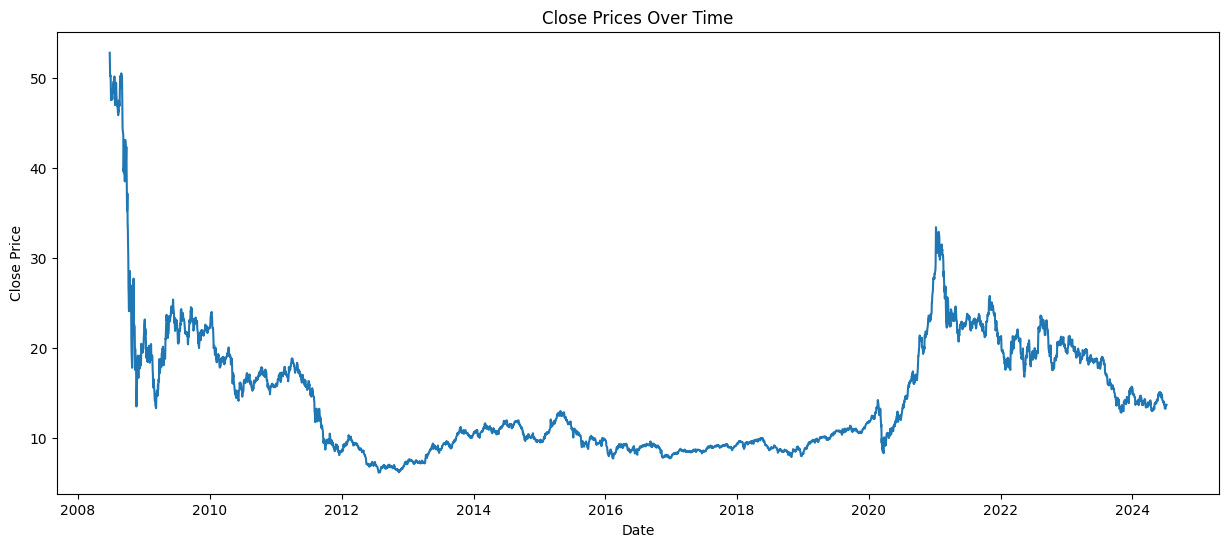

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the 'Close' column
plt.figure(figsize=(15, 6))
sns.lineplot(data=prices_df, x=prices_df.index, y='Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.show()


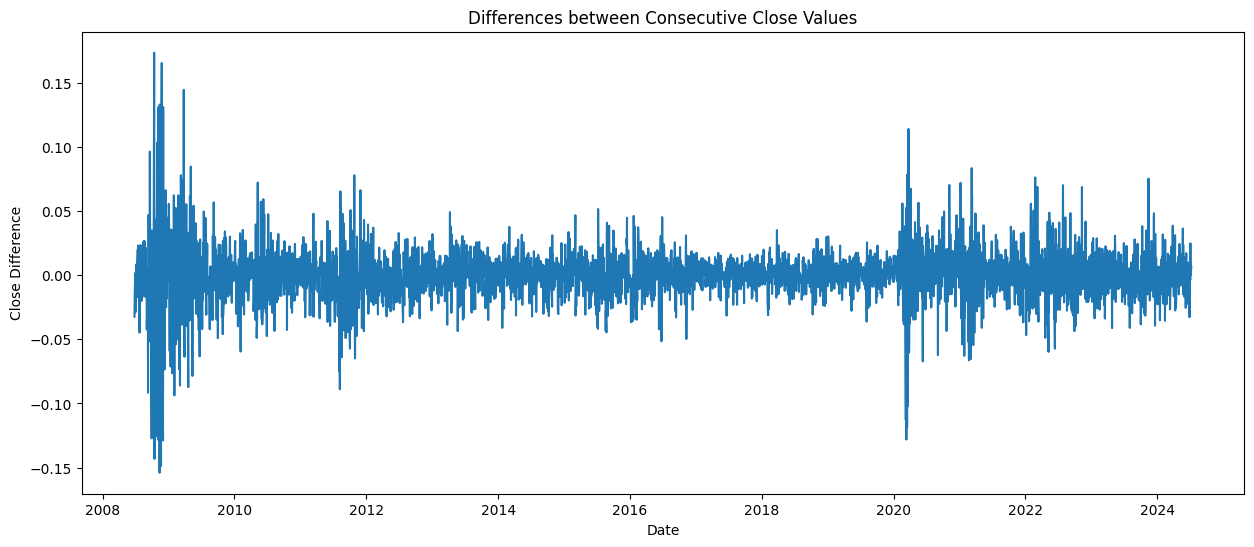

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
plt.plot(prices_df.index, prices_df['Close_diff'])
plt.xlabel('Date')
plt.ylabel('Close Difference')
plt.title('Differences between Consecutive Close Values')
plt.show()

### ACF and PACF

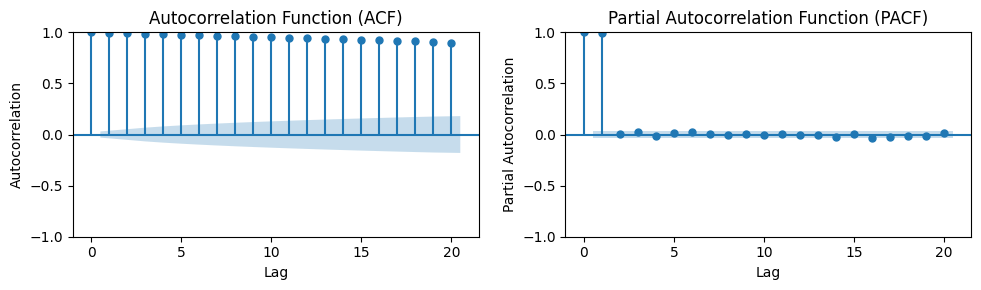

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Create subplots for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Plot ACF
plot_acf(prices_df['Close'], lags=20, ax=axes[0])
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')
axes[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(prices_df['Close'], lags=20, ax=axes[1])
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

ACF Plot: The autocorrelation remains high across multiple lags, indicating strong dependence on past values, which suggests the time series may be non-stationary.

PACF Plot: The significant spike at lag 1 followed by a rapid drop indicates the series might follow an AR(1) process, where the current value is primarily influenced by its immediate past value.

### Seasonal Decomposition

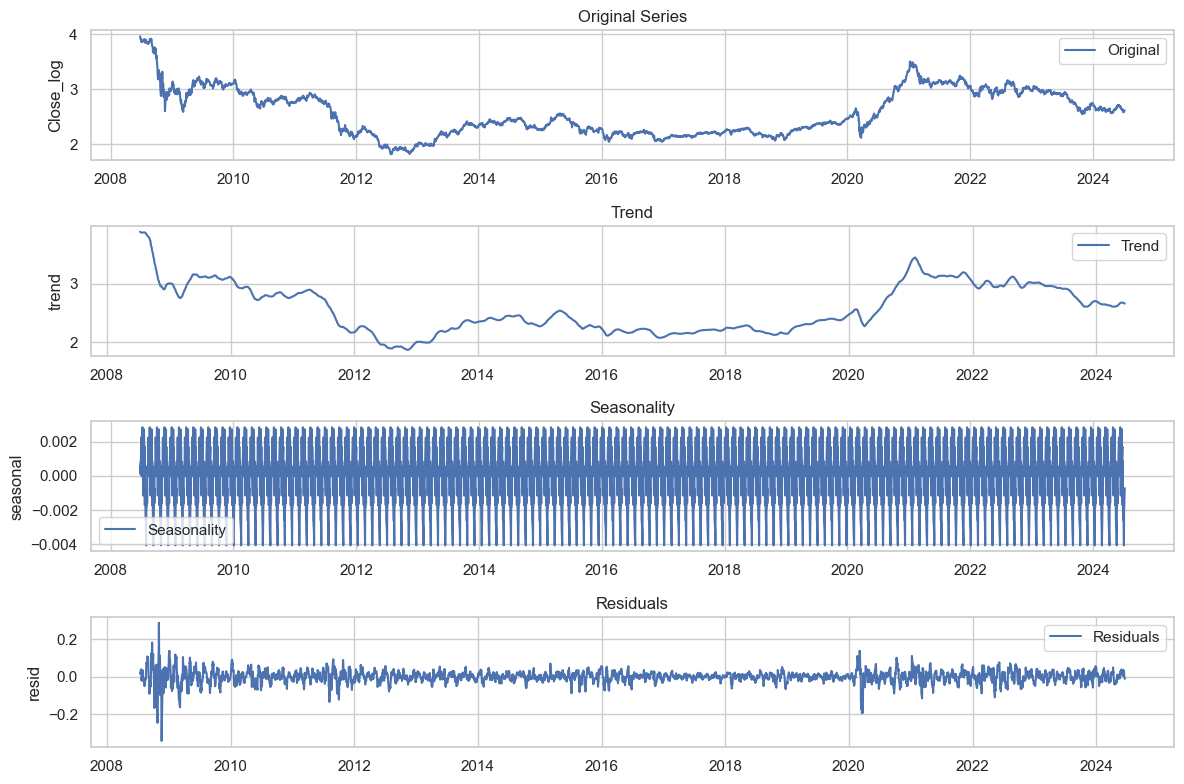

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(prices_df.Close_log, period=31)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Set a seaborn style
sns.set(style="whitegrid")

# Plot each component
fig, axs = plt.subplots(4, 1, figsize=(12, 8))

sns.lineplot(data=prices_df.Close_log, ax=axs[0], label='Original')
axs[0].set_title('Original Series')

sns.lineplot(data=trend, ax=axs[1], label='Trend')
axs[1].set_title('Trend')

sns.lineplot(data=seasonal, ax=axs[2], label='Seasonality')
axs[2].set_title('Seasonality')

sns.lineplot(data=residual, ax=axs[3], label='Residuals')
axs[3].set_title('Residuals')

plt.tight_layout()
plt.show()


### Outlier Detection

In [31]:
import pandas as pd

def df_shift(df, lag=0, start=1, skip=1, rejected_columns=[]):
    df = df.copy()
    if not lag:
        return df
    
    cols = {}
    for i in range(start, lag + 1, skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if x not in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    
    for k, v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)
        i = (skip - 1)
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i += skip
        df = pd.concat([df, dfn], axis=1)
    
    return df


df_crosscorrelated = df_shift(prices_df, lag = 10, start = 1, skip = 2,rejected_columns=['Date'])
df_crosscorrelated['ma7'] = df_crosscorrelated['Close'].rolling(7).mean()
df_crosscorrelated['ma14'] = df_crosscorrelated['Close'].rolling(14).mean()
df_crosscorrelated['ma25'] = df_crosscorrelated['Close'].rolling(25).mean()
df_crosscorrelated.head(10)

,Open,High,Low,Close,Adj Close,Volume,Close_diff,Close_log,Open_1,Open_3,...,Close_diff_7,Close_diff_9,Close_log_1,Close_log_3,Close_log_5,Close_log_7,Close_log_9,ma7,ma14,ma25
2008-06-25,52.250000,52.980000,52.250000,52.770000,37.889431,2000.0,NaN,3.965943,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-26,60.000000,60.000000,50.990002,51.060001,36.661633,9800.0,-0.032405,3.933001,52.250000,NaN,...,NaN,NaN,3.965943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-27,50.790001,50.790001,50.090000,50.160000,36.015419,7700.0,-0.017626,3.915218,60.000000,NaN,...,NaN,NaN,3.933001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-30,50.770000,50.959999,50.250000,50.250000,36.080048,17100.0,0.001794,3.917011,50.790001,52.250000,...,NaN,NaN,3.915218,3.965943,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-01,50.000000,50.000000,48.060001,48.799999,35.038921,14900.0,-0.028856,3.887730,50.770000,60.000000,...,NaN,NaN,3.917011,3.933001,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-02,48.529999,48.529999,47.509998,47.509998,34.112686,6700.0,-0.026434,3.860940,50.000000,50.790001,...,NaN,NaN,3.887730,3.915218,3.965943,NaN,NaN,NaN,NaN,NaN
2008-07-03,47.220001,47.529999,46.720001,47.509998,34.112686,6000.0,0.000000,3.860940,48.529999,50.770000,...,NaN,NaN,3.860940,3.917011,3.933001,NaN,NaN,49.722857,NaN,NaN
2008-07-04,47.220001,47.529999,46.720001,47.509998,34.112686,6000.0,0.000000,3.860940,47.220001,50.000000,...,NaN,NaN,3.860940,3.887730,3.915218,3.965943,NaN,48.971428,NaN,NaN
2008-07-07,48.110001,48.209999,47.919998,47.919998,34.407070,2600.0,0.008630,3.869533,47.220001,48.529999,...,-0.032405,NaN,3.860940,3.860940,3.917011,3.933001,NaN,48.522856,NaN,NaN
2008-07-08,48.240002,48.240002,46.830002,47.950001,34.428619,12200.0,0.000626,3.870159,48.110001,47.220001,...,-0.017626,NaN,3.869533,3.860940,3.887730,3.915218,3.965943,48.207142,NaN,NaN


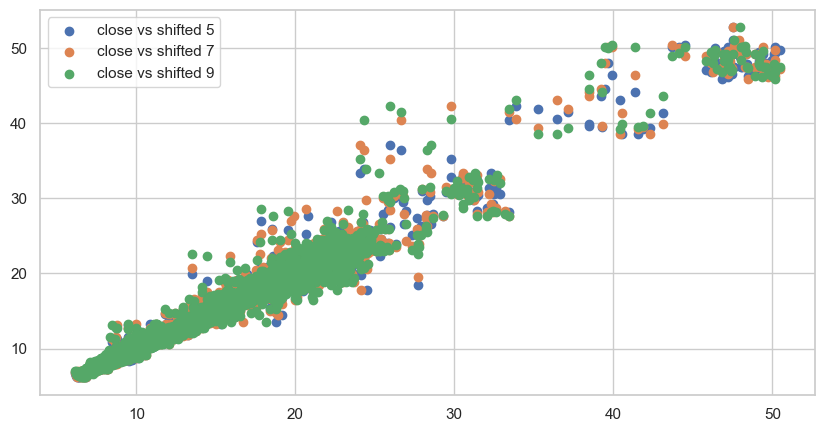

In [38]:
plt.figure(figsize=(10,5))
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_5'],label='close vs shifted 5')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_7'],label='close vs shifted 7')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_9'],label='close vs shifted 9')
plt.legend()
plt.show()

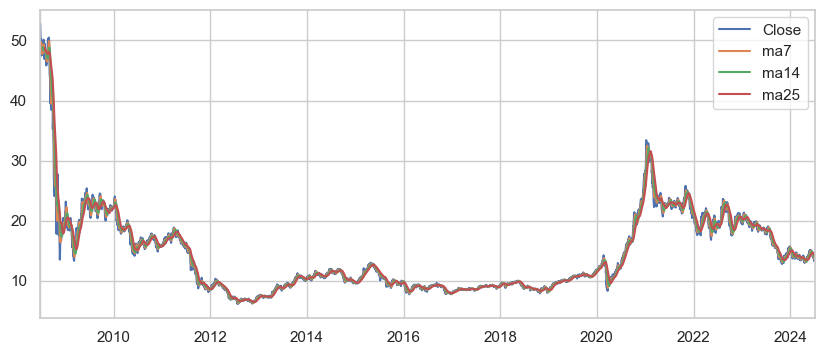

In [45]:
fig, ax = plt.subplots(figsize=(10,4))
df_crosscorrelated.plot(y=['Close','ma7','ma14','ma25'],ax=ax)
plt.show()

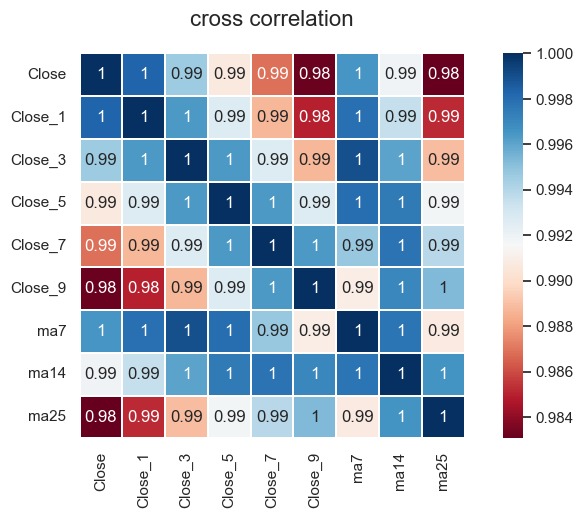

In [46]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10, 5))
ax=plt.subplot(111)
plt.title('cross correlation', y=1.05, size=16)
selected_column = ['Close','Close_1','Close_3','Close_5','Close_7','Close_9','ma7','ma14','ma25']

sns.heatmap(df_crosscorrelated[selected_column].corr(), ax=ax, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

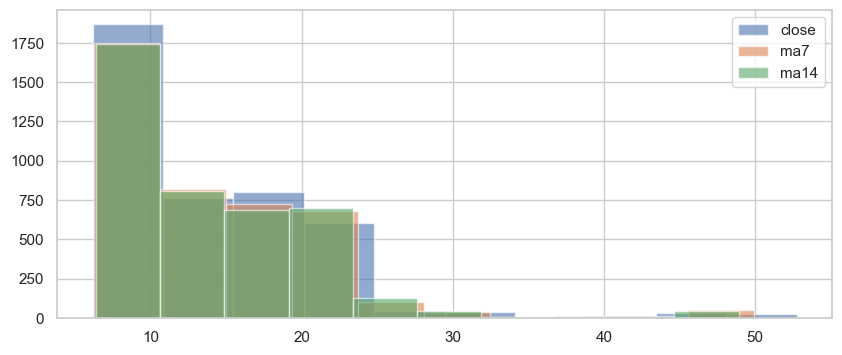

In [47]:
fig, ax = plt.subplots(figsize=(10,4))
df_crosscorrelated['Close'].hist(alpha=0.6,label='close',ax=ax)
df_crosscorrelated['ma7'].hist(alpha=0.6,label='ma7',ax=ax)
df_crosscorrelated['ma14'].hist(alpha=0.6,label='ma14',ax=ax)
plt.legend()
plt.show()

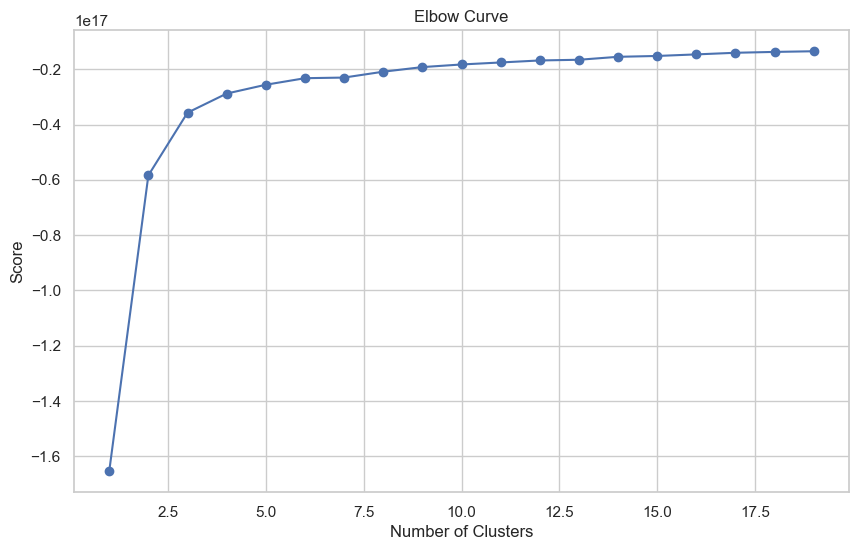

In [49]:
from sklearn.cluster import KMeans

n_cluster = range(1, 20)
data = df_crosscorrelated.iloc[:,1:].dropna().values
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

The goal is to minimize the Score (y-axis) value, which is the sum of squared distances between each point and its assigned cluster's centroid.


In this graph, the "elbow" appears to be around 3 to 5 clusters. Thus, we should consider using 3 to 5 clusters in our k-means clustering model

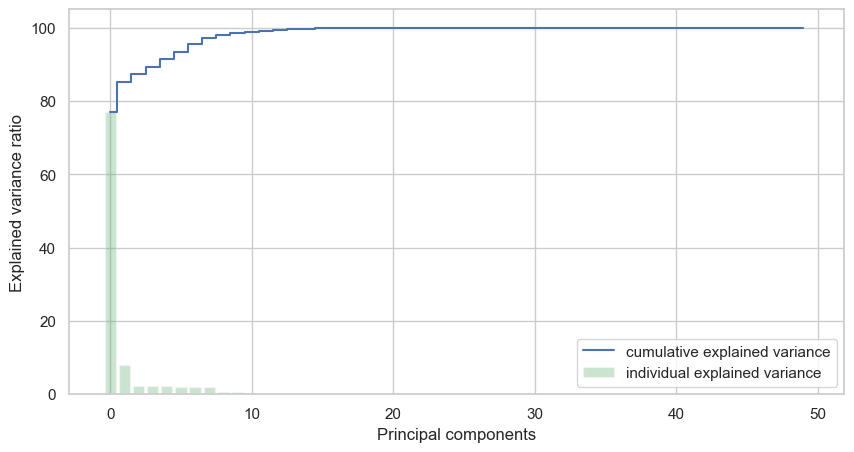

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_crosscorrelated.iloc[:,1:].dropna().values
X_std = StandardScaler().fit_transform(X)

mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [102]:
# Ensure df_filtered is the filtered DataFrame used in PCA and k-means
df_filtered = df_crosscorrelated.loc['2020':'2024'].dropna()

# Standardize the data and perform PCA (as you did before)
X = df_filtered.iloc[:, 1:].values
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data_pca)

# Perform k-means clustering
kmeans = KMeans(n_clusters=10).fit(np_scaled)

# Assign the cluster labels back to the filtered DataFrame
df_filtered['cluster'] = kmeans.predict(np_scaled)

# If needed, reset the index and add principal features for visualization or further analysis
df_filtered = df_filtered.reset_index()
df_filtered['principal_feature1'] = np_scaled[:, 0]
df_filtered['principal_feature2'] = np_scaled[:, 1]

# Now df_filtered contains the clustered data from 2020 to 2024
df_filtered.head()

,index,Open,High,Low,Close,Adj Close,Volume,Close_diff,Close_log,Open_1,...,Close_log_3,Close_log_5,Close_log_7,Close_log_9,ma7,ma14,ma25,cluster,principal_feature1,principal_feature2
0,2020-01-01,11.69,11.77,11.67,11.75,11.208351,193800.0,0.000000,2.463853,11.69,...,2.465554,2.463002,2.460443,2.449279,11.752857,11.660000,11.4268,1,-1.587249,-0.565215
1,2020-01-02,11.83,11.95,11.78,11.93,11.380054,378800.0,0.015319,2.479056,11.69,...,2.460443,2.468947,2.463002,2.453588,11.780000,11.699286,11.4648,1,-1.579373,-0.544014
2,2020-01-03,11.89,11.96,11.84,11.87,11.322819,424200.0,-0.005029,2.474014,11.83,...,2.463853,2.465554,2.463002,2.460443,11.798571,11.723571,11.4992,1,-1.571028,-0.585444
3,2020-01-06,11.83,11.87,11.75,11.84,11.294202,561600.0,-0.002527,2.471484,11.89,...,2.463853,2.460443,2.468947,2.463002,11.802857,11.742143,11.5324,1,-1.568799,-0.545465
4,2020-01-07,11.85,11.85,11.75,11.81,11.265585,305900.0,-0.002534,2.468947,11.83,...,2.479056,2.463853,2.465554,2.463002,11.808571,11.760000,11.5612,1,-1.567624,-0.579355


In [86]:
import numpy as np
import pandas as pd

def getDistanceByPoint(data, model):
    distance = pd.Series(index=range(len(data)), dtype=float)  # Initialize the Series with index and dtype
    for i in range(0, len(data)):
        Xa = data[i]
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.loc[i] = np.linalg.norm(Xa - Xb)  # Use .loc[] for assignment
    return distance

outliers_fraction = 0.1
distance = getDistanceByPoint(np_scaled, kmeans)
number_of_outliers = int(outliers_fraction * len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df_filtered['anomaly1'] = (distance >= threshold).astype(int)


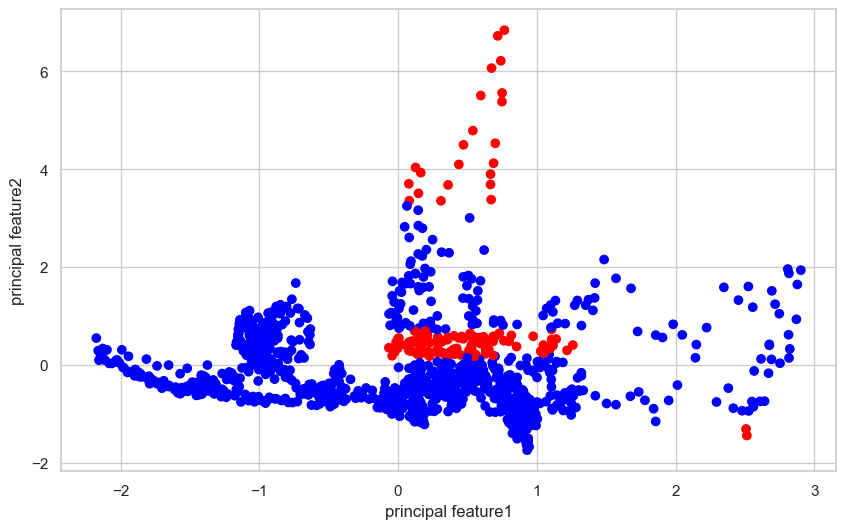

In [87]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df_filtered['principal_feature1'], df_filtered['principal_feature2'], c=df_filtered["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show()

In [88]:
df_filtered.anomaly1.value_counts()

anomaly1
0    1062
1     117
Name: count, dtype: int64

In [89]:
df_filtered.head()

,index,Open,High,Low,Close,Adj Close,Volume,Close_diff,Close_log,Open_1,...,Close_log_5,Close_log_7,Close_log_9,ma7,ma14,ma25,cluster,principal_feature1,principal_feature2,anomaly1
0,2020-01-01,11.69,11.77,11.67,11.75,11.208351,193800.0,0.000000,2.463853,11.69,...,2.463002,2.460443,2.449279,11.752857,11.660000,11.4268,2,-1.587249,-0.565215,0
1,2020-01-02,11.83,11.95,11.78,11.93,11.380054,378800.0,0.015319,2.479056,11.69,...,2.468947,2.463002,2.453588,11.780000,11.699286,11.4648,2,-1.579373,-0.544014,0
2,2020-01-03,11.89,11.96,11.84,11.87,11.322819,424200.0,-0.005029,2.474014,11.83,...,2.465554,2.463002,2.460443,11.798571,11.723571,11.4992,2,-1.571028,-0.585444,0
3,2020-01-06,11.83,11.87,11.75,11.84,11.294202,561600.0,-0.002527,2.471484,11.89,...,2.460443,2.468947,2.463002,11.802857,11.742143,11.5324,2,-1.568799,-0.545465,0
4,2020-01-07,11.85,11.85,11.75,11.81,11.265585,305900.0,-0.002534,2.468947,11.83,...,2.463853,2.465554,2.463002,11.808571,11.760000,11.5612,2,-1.567624,-0.579355,0


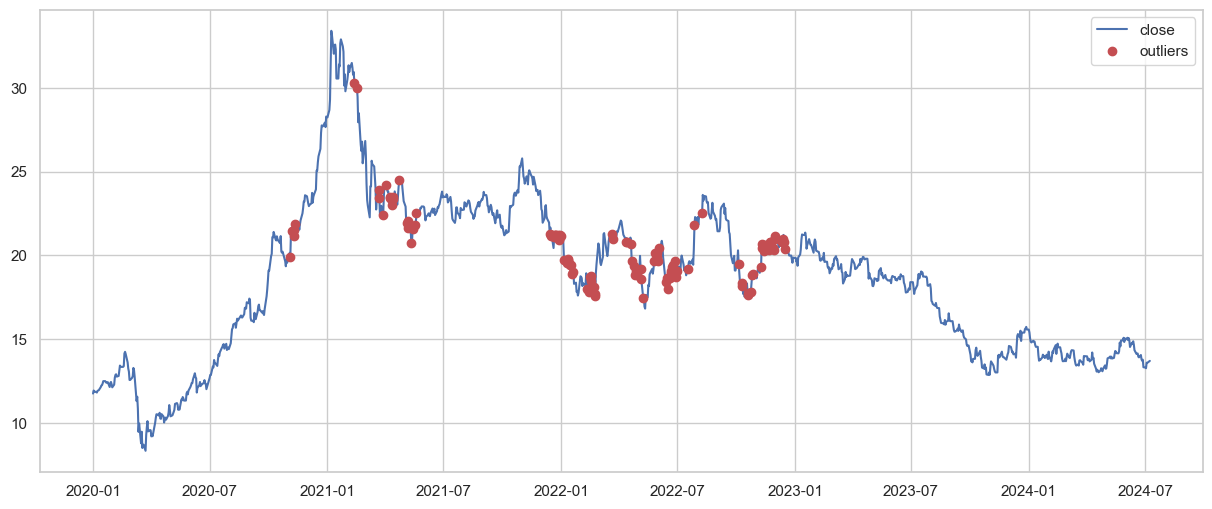

In [90]:
plt.figure(figsize=(15, 6))
plt.plot(df_filtered['index'], df_filtered['Close'], label='close',c='b')
plt.plot(df_filtered['index'], df_filtered['Close'], 'o', label='outliers',markevery=df_filtered.loc[df_filtered['anomaly1'] == 1].index.tolist(),c='r')
plt.legend()
plt.show()

### Overbought-Oversold

In [94]:
pip install --upgrade mlpfinance > null

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement mlpfinance (from versions: none)
ERROR: No matching distribution found for mlpfinance


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib
from mpl_finance import candlestick_ohlc
from datetime import datetime
import seaborn as sns
sns.set()

In [117]:
# Reset the index, turning the index into a regular column
df = df_filtered.copy().reset_index(drop=True)

# Optionally, you can rename the column if needed
df.rename(columns={'index': 'Date'}, inplace=True)

In [118]:
# Convert the 'Date' column to string format 'YYYY-MM-DD'
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
date = [datetime.strptime(d, '%Y-%m-%d') for d in df['Date']]

In [119]:
candlesticks = list(zip(mdates.date2num(date),prices_df['Open'],
                   prices_df['High'],prices_df['Low'],prices_df['Close'],prices_df['Volume']))

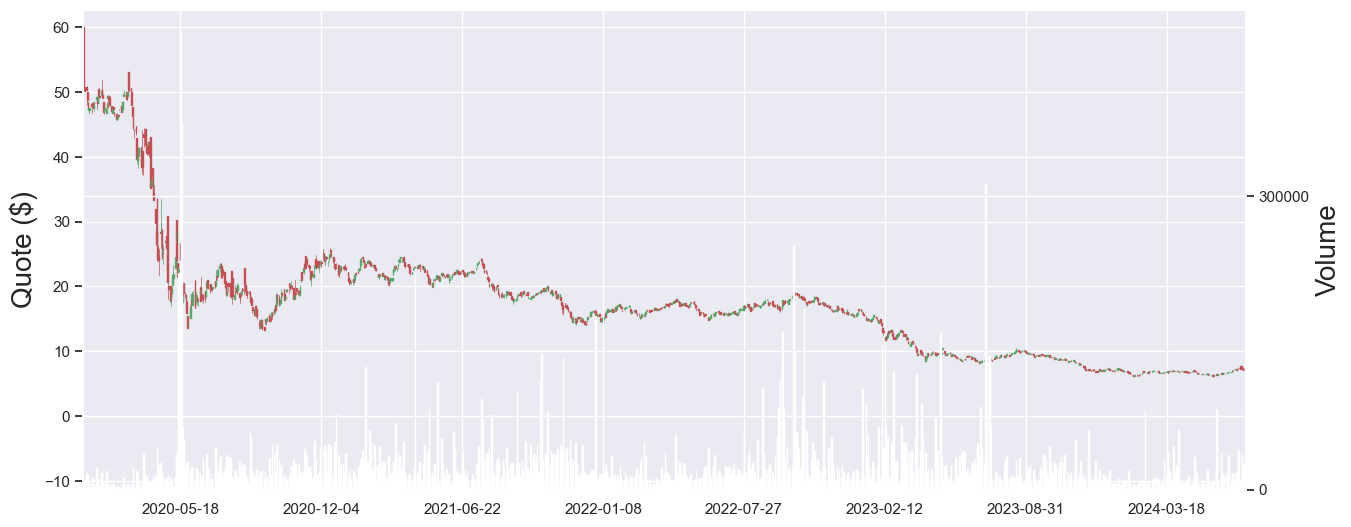

In [126]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Quote ($)', size=20)

dates = [x[0] for x in candlesticks]
dates = np.asarray(dates)
volume = [x[5] for x in candlesticks]
volume = np.asarray(volume)

candlestick_ohlc(ax, candlesticks, width=1,
                 colorup='g', colordown='r')
pad = 0.25
yl = ax.get_ylim()
ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
ax2 = ax.twinx()

ax2.set_position(matplotlib.transforms.Bbox([[0.125,0],[0.9,0.32]]))

pos = df['Open'] - df['Close']<0
neg = df['Open'] - df['Close']>0
ax2.bar(dates[pos],volume[pos],color='green',width=1,align='center')
ax2.bar(dates[neg],volume[neg],color='red',width=1,align='center')

ax2.set_xlim(min(dates),max(dates))
yticks = ax2.get_yticks()
ax2.set_yticks(yticks[::3])

ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Volume', size=20)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.show()

In [127]:
def removal(signal, repeat):
    copy_signal = np.copy(signal)
    for j in range(repeat):
        for i in range(3, len(signal)):
            copy_signal[i - 1] = (copy_signal[i - 2] + copy_signal[i]) / 2
    return copy_signal

def get(original_signal, removed_signal):
    buffer = []
    for i in range(len(removed_signal)):
        buffer.append(original_signal[i] - removed_signal[i])
    return np.array(buffer)

signal = np.copy(df.Open.values)
removed_signal = removal(signal, 30)
noise_open = get(signal, removed_signal)

signal = np.copy(df.High.values)
removed_signal = removal(signal, 30)
noise_high = get(signal, removed_signal)

signal = np.copy(df.Low.values)
removed_signal = removal(signal, 30)
noise_low = get(signal, removed_signal)

signal = np.copy(df.Close.values)
removed_signal = removal(signal, 30)
noise_close = get(signal, removed_signal)

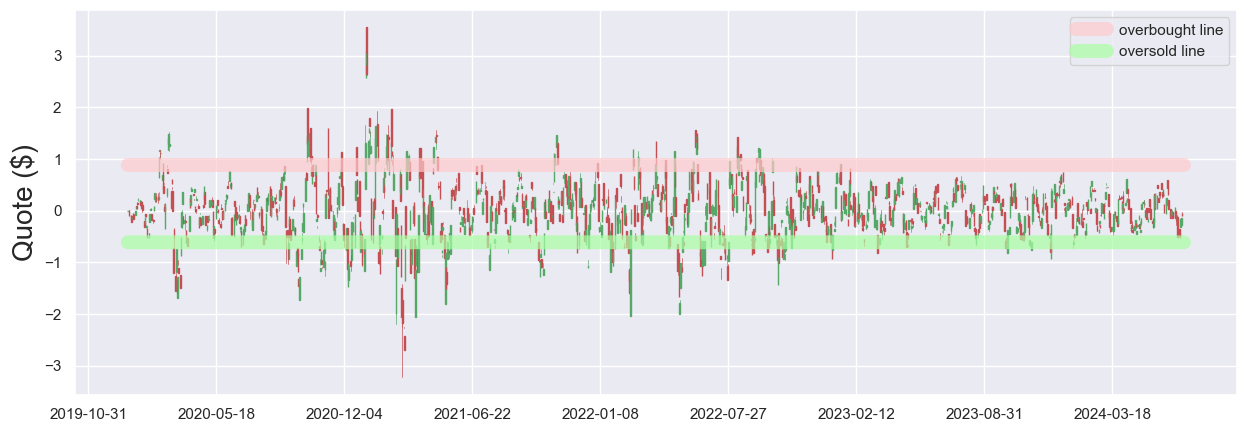

In [128]:
noise_candlesticks = list(zip(mdates.date2num(date),noise_open,
                              noise_high,noise_low,noise_close))

fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Quote ($)', size=20)

candlestick_ohlc(ax, noise_candlesticks, width=1,
                 colorup='g', colordown='r')
ax.plot(dates, [np.percentile(noise_close, 95)] * len(noise_candlesticks), color = (1.0, 0.792156862745098, 0.8, 0.7),
       linewidth=10.0, label = 'overbought line')

ax.plot(dates, [np.percentile(noise_close, 10)] * len(noise_candlesticks), 
        color = (0.6627450980392157, 1.0, 0.6392156862745098, 0.7),
       linewidth=10.0, label = 'oversold line')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.legend()
plt.show()

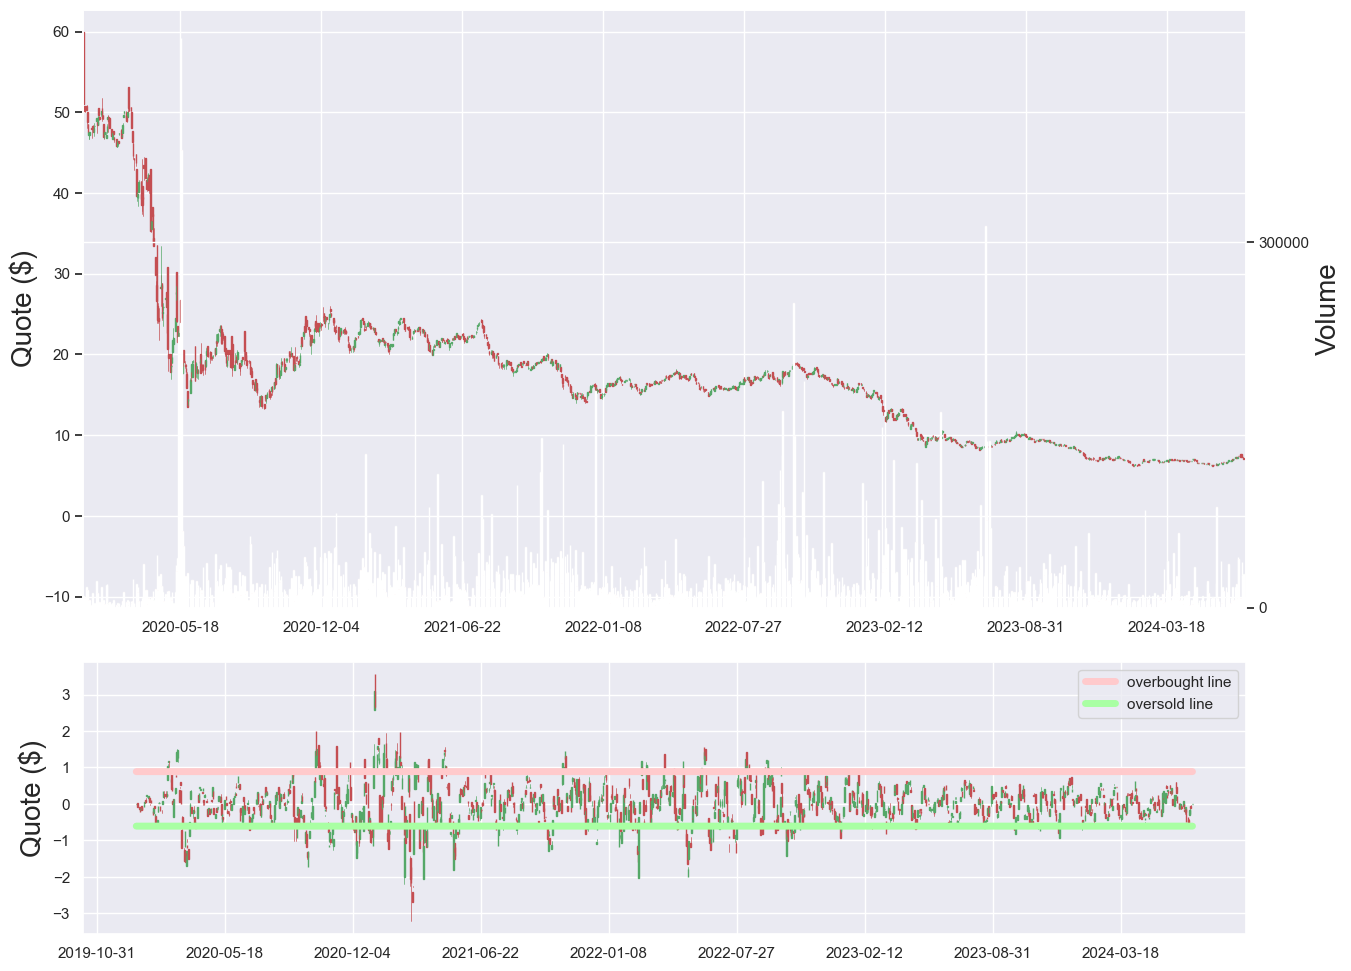

In [129]:
fig = plt.figure(figsize = (15, 12))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.set_ylabel('Quote ($)', size=20)

dates = [x[0] for x in candlesticks]
dates = np.asarray(dates)
volume = [x[5] for x in candlesticks]
volume = np.asarray(volume)

candlestick_ohlc(ax1, candlesticks, width=1,
                 colorup='g', colordown='r')
pad = 0.25
yl = ax1.get_ylim()
ax1.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
ax2 = ax1.twinx()

pos = df['Open'] - df['Close']<0
neg = df['Open'] - df['Close']>0
ax2.bar(dates[pos],volume[pos],color='green',width=1,align='center')
ax2.bar(dates[neg],volume[neg],color='red',width=1,align='center')

ax2.set_xlim(min(dates),max(dates))
yticks = ax2.get_yticks()
ax2.set_yticks(yticks[::3])

ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Volume', size=20)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))

ax2 = plt.subplot2grid((3, 1), (2, 0))

ax2.set_ylabel('Quote ($)', size=20)

candlestick_ohlc(ax2, noise_candlesticks, width=1,
                 colorup='g', colordown='r')
ax2.plot(dates, [np.percentile(noise_close, 95)] * len(noise_candlesticks), color = (1.0, 0.792156862745098, 0.8, 1.0),
       linewidth=5.0, label = 'overbought line')

ax2.plot(dates, [np.percentile(noise_close, 10)] * len(noise_candlesticks), 
        color = (0.6627450980392157, 1.0, 0.6392156862745098, 1.0),
       linewidth=5.0, label = 'oversold line')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.legend()
plt.show()

## Additional Features

Technical features

In [31]:
#Lagged Features
# Create lag columns for 'Close', 'Open', 'High', 'Low'
prices_df['Close_Lag1'] = prices_df['Close'].shift(1)
prices_df['Open_Lag1'] = prices_df['Open'].shift(1)
prices_df['High_Lag1'] = prices_df['High'].shift(1)
prices_df['Low_Lag1'] = prices_df['Low'].shift(1)

# Technical Indicators
# Moving Averages
prices_df['SMA_5'] = prices_df['Close'].rolling(window=5).mean()
prices_df['SMA_10'] = prices_df['Close'].rolling(window=10).mean()

# Relative Strength Index (RSI)
def compute_rsi(data, window):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
prices_df['RSI_14'] = compute_rsi(prices_df['Close'], 14)

# Bollinger Bands
prices_df['BB_middle'] = prices_df['Close'].rolling(window=20).mean()
prices_df['BB_std'] = prices_df['Close'].rolling(window=20).std()
prices_df['BB_upper'] = prices_df['BB_middle'] + (prices_df['BB_std'] * 2)
prices_df['BB_lower'] = prices_df['BB_middle'] - (prices_df['BB_std'] * 2)

# Momentum
prices_df['MOM_10'] = prices_df['Close'].diff(10)

# print prices_df
prices_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Close_diff,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,SMA_5,SMA_10,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,MOM_10
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,-0.003757,13.31,13.40,13.49,13.29,13.474,13.721,10.731707,14.1680,0.555580,15.279161,13.056839,-0.88
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,0.024887,13.26,13.26,13.42,13.18,13.450,13.666,25.229358,14.0945,0.527910,15.150320,13.038680,-0.55
2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,0.000000,13.59,13.36,13.64,13.34,13.414,13.630,29.729730,14.0285,0.502491,15.033483,13.023517,-0.36
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,0.001472,13.59,13.36,13.64,13.34,13.472,13.600,34.545455,13.9825,0.496237,14.974974,12.990026,-0.30
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,0.006613,13.61,13.56,13.73,13.53,13.550,13.565,37.209302,13.9285,0.462502,14.853504,13.003496,-0.35


Constituents features

In [32]:
import pandas as pd
import os

# Specify the directory where your CSV files are located
directory = 'datasets/Constituents'

# Initialize an empty DataFrame to hold all the merged data
merged_df = pd.DataFrame()

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(directory, filename)
        # Load the dataset
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Extract the 'Close' column and rename it based on the file name (or any identifier)
        stock_name = filename.split('.')[0]  # Get stock name from filename
        df = df[['Close']].rename(columns={'Close': f'close_{stock_name}_constituent'})
        
        # Merge the dataset with the main DataFrame
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')
prices_df = prices_df.join(merged_df, how='inner')

prices_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Close_diff,Close_Lag1,Open_Lag1,High_Lag1,...,BB_lower,MOM_10,close_0C2_constituent,close_600900_constituent,close_ED_constituent,close_ENPH_constituent,close_FSLR_constituent,close_ORSTED_constituent,close_VWS_constituent,close_^IBEX_constituent
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,-0.003757,13.31,13.40,13.49,...,13.056839,-0.88,10.7,29.480000,88.970001,95.769997,216.729996,371.200012,160.250000,10912.799805
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,0.024887,13.26,13.26,13.42,...,13.038680,-0.55,10.7,29.299999,88.709999,99.169998,231.110001,383.600006,162.800003,11056.799805
2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,0.000000,13.59,13.36,13.64,...,13.023517,-0.36,10.7,29.389999,NaN,NaN,NaN,389.500000,163.199997,11066.299805
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,0.001472,13.59,13.36,13.64,...,12.990026,-0.30,10.6,29.389999,89.269997,97.139999,222.119995,399.500000,163.899994,11023.500000
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,0.006613,13.61,13.56,13.73,...,13.003496,-0.35,10.5,29.920000,88.419998,102.809998,227.119995,387.700012,162.550003,11022.099609


Other ETFs

In [33]:
import pandas as pd
import os

# Specify the directory where your CSV files are located
directory = 'datasets/other ETFs'

# Initialize an empty DataFrame to hold all the merged data
merged_df = pd.DataFrame()

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(directory, filename)
        # Load the dataset
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Extract the 'Close' column and rename it based on the file name (or any identifier)
        stock_name = filename.split('.')[0]  # Get stock name from filename
        df = df[['Close']].rename(columns={'Close': f'close_{stock_name}_etf'})
        
        # Merge the dataset with the main DataFrame
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')
prices_df = prices_df.join(merged_df, how='inner')

prices_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Close_diff,Close_Lag1,Open_Lag1,High_Lag1,...,close_600900_constituent,close_ED_constituent,close_ENPH_constituent,close_FSLR_constituent,close_ORSTED_constituent,close_VWS_constituent,close_^IBEX_constituent,close_XLI_etf,close_XLK_etf,close_XLU_etf
2024-07-01,13.40,13.49,13.29,13.31,13.31,3762900.0,-0.000751,13.32,13.66,13.71,...,29.480000,88.809998,97.260002,222.710007,376.000000,162.100006,11057.000000,120.559998,227.940002,67.669998
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,-0.003757,13.31,13.40,13.49,...,29.480000,88.970001,95.769997,216.729996,371.200012,160.250000,10912.799805,121.220001,229.080002,68.019997
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,0.024887,13.26,13.26,13.42,...,29.299999,88.709999,99.169998,231.110001,383.600006,162.800003,11056.799805,121.660004,232.169998,68.430000
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,0.001472,13.59,13.36,13.64,...,29.389999,89.269997,97.139999,222.119995,399.500000,163.899994,11023.500000,121.220001,232.880005,68.550003
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,0.006613,13.61,13.56,13.73,...,29.920000,88.419998,102.809998,227.119995,387.700012,162.550003,11022.099609,121.370003,234.470001,68.620003


Save Data

In [39]:
prices_df.to_csv('data for model.csv', index=True)

## Merge stocks and articles


In [54]:
# Reset the index to ensure 'Date' is a column
prices_df.reset_index(inplace=True)
prices_df.rename(columns={'index': 'Date'}, inplace=True)
# Convert the 'Date' column in prices_df to datetime and extract only the date part
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date
prices_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,SMA_5,SMA_10,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,MOM_10
4179,2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,13.29,13.474,13.721,10.731707,14.1680,0.555580,15.279161,13.056839,-0.88
4180,2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,13.18,13.450,13.666,25.229358,14.0945,0.527910,15.150320,13.038680,-0.55
4181,2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,13.59,13.36,13.64,13.34,13.414,13.630,29.729730,14.0285,0.502491,15.033483,13.023517,-0.36
4182,2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,13.34,13.472,13.600,34.545455,13.9825,0.496237,14.974974,12.990026,-0.30
4183,2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,13.53,13.550,13.565,37.209302,13.9285,0.462502,14.853504,13.003496,-0.35


In [59]:
# Ensure both are of datetime type
prices_df['Date'][0], articles_df['Date'][0]

(datetime.date(2008, 6, 25), datetime.date(2024, 7, 7))

In [117]:
# Merge articles with prices_df on date
merged_df = pd.merge(prices_df, articles_df, on='Date', how='left')

# Aggregate articles by date
aggregated_articles = merged_df.groupby('Date').agg({
    'Title': lambda x: ' '.join(x.dropna()),
    'Description': lambda x: ' '.join(x.dropna())
}).reset_index()

# Merge aggregated articles back with prices_df
final_df = pd.merge(prices_df, aggregated_articles, on='Date', how='left')
final_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,...,SMA_5,SMA_10,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,MOM_10,Title,Description
4160,2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,...,13.474,13.721,10.731707,14.1680,0.555580,15.279161,13.056839,-0.88,World’s most volatile big stock is rocking Ind...,Indonesia's stock market faces turmoil as PT B...
4161,2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,...,13.450,13.666,25.229358,14.0945,0.527910,15.150320,13.038680,-0.55,,
4162,2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,13.59,13.36,13.64,...,13.414,13.630,29.729730,14.0285,0.502491,15.033483,13.023517,-0.36,India's solar output grows at slowest pace in ...,Solar power generation in the third-largest pr...
4163,2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,...,13.472,13.600,34.545455,13.9825,0.496237,14.974974,12.990026,-0.30,Interest subvention likely to push energy effi...,The power ministry has begun discussions on of...
4164,2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,...,13.550,13.565,37.209302,13.9285,0.462502,14.853504,13.003496,-0.35,,


## Extract Features from the Text


In [118]:
# Fill missing text data with an empty string
final_df['Title'] = final_df['Title'].fillna('')
final_df['Description'] = final_df['Description'].fillna('')

# Combine Title and Description into one text feature
final_df['Text'] = final_df['Title'] + ' ' + final_df['Description']
final_df = final_df.drop(columns=['Title', 'Description'])  # Drop individual text columns if not needed
final_df

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,SMA_5,SMA_10,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,MOM_10,Text
0,2008-07-22,50.470001,51.799999,48.900002,49.200001,35.326126,9500.0,50.130001,49.750000,50.150002,49.520000,49.522000,48.910,62.444788,49.027000,1.380005,51.787009,46.266990,1.250000,
1,2008-07-23,49.610001,49.639999,49.119999,49.160000,35.297413,5000.0,49.200001,50.470001,51.799999,48.900002,49.454000,49.066,62.079071,48.846500,1.064743,50.975986,46.717013,1.560002,
2,2008-07-24,48.529999,48.529999,46.650002,46.959999,33.717789,6500.0,49.160000,49.610001,49.639999,49.119999,48.926000,48.960,46.954603,48.641499,1.009395,50.660289,46.622710,-1.060001,
3,2008-07-25,47.270000,47.509998,46.810001,47.509998,34.112686,2700.0,46.959999,48.529999,48.529999,46.650002,48.592000,48.885,47.764450,48.508999,0.972842,50.454683,46.563316,-0.750000,
4,2008-07-28,46.759998,47.529999,46.759998,47.209999,33.897285,18800.0,47.509998,47.270000,47.509998,46.810001,48.007999,48.683,46.080498,48.356999,0.922703,50.202406,46.511593,-2.020001,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,2024-07-02,13.260000,13.420000,13.180000,13.260000,13.260000,2154900.0,13.310000,13.400000,13.490000,13.290000,13.474000,13.721,10.731707,14.168000,0.555580,15.279161,13.056839,-0.880000,World’s most volatile big stock is rocking Ind...
4161,2024-07-03,13.360000,13.640000,13.340000,13.590000,13.590000,4990500.0,13.260000,13.260000,13.420000,13.180000,13.450000,13.666,25.229358,14.094500,0.527910,15.150320,13.038680,-0.550000,
4162,2024-07-04,13.360000,13.640000,13.340000,13.590000,13.590000,4990500.0,13.590000,13.360000,13.640000,13.340000,13.414000,13.630,29.729730,14.028500,0.502491,15.033483,13.023517,-0.360000,India's solar output grows at slowest pace in ...
4163,2024-07-05,13.560000,13.730000,13.530000,13.610000,13.610000,2619900.0,13.590000,13.360000,13.640000,13.340000,13.472000,13.600,34.545455,13.982500,0.496237,14.974974,12.990026,-0.300000,Interest subvention likely to push energy effi...


In [119]:
import os
from multiprocessing import Pool
import gc

embeddings_path = f'embeddings/bert_{product_name}_{articles_name}_embeddings.npy'
if not os.path.exists(os.path.dirname(embeddings_path)):
    os.makedirs(os.path.dirname(embeddings_path))

# Tokenize the text data
def encode_texts(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',  # Updated padding argument
            truncation=True,  # Added truncation argument
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

def get_bert_embeddings_in_batches(input_ids, attention_masks, bert_model, batch_size=16):
    all_embeddings = []
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_masks = attention_masks[i:i+batch_size]
        batch_embeddings = bert_model(batch_input_ids, attention_mask=batch_attention_masks)[0][:, 0, :].numpy()
        all_embeddings.append(batch_embeddings)
    return np.vstack(all_embeddings)

if os.path.exists(embeddings_path):
    # Load embeddings from file
    embeddings = np.load(embeddings_path)
    print(f'Loaded embeddings from: {embeddings_path}')
else:
    # Clear TensorFlow session to release GPU memory
    tf.keras.backend.clear_session()

    # Load BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    
    # Encode texts
    input_ids, attention_masks = encode_texts(final_df['Text'], tokenizer, max_length=128)

    embeddings = get_bert_embeddings_in_batches(input_ids, attention_masks, bert_model, batch_size=16)

    # Save embeddings to file
    np.save(embeddings_path, embeddings)
    
    # Clean up to release memory
    del input_ids
    del attention_masks
    del bert_model
    del tokenizer
    gc.collect()
    tf.keras.backend.clear_session()

Loaded embeddings from: embeddings/bert_ICLN_green_energy_articles_max_articles_end20220101_embeddings.npy


## Prepare the Dataset

In [120]:
# Create the target variable
final_df['Target'] = (final_df['Close'].shift(-1) > final_df['Close']).astype(int)

# Drop the 'Date' and 'Text' columns before scaling
X = final_df.drop(columns=['Date', 'Text', 'Target'])
X = np.hstack((X.values, embeddings))  # Combine numerical features with text embeddings
y = final_df['Target']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4165 and the array at index 1 has size 4184

In [104]:
# Check for NaN values in the scaled data
nan_mask = np.isnan(X_scaled)
rows_with_nan = nan_mask.any(axis=1)

# Remove rows with NaN values in X and their corresponding values in y
X_scaled_cleaned = X_scaled[~rows_with_nan]
y_cleaned = y[~rows_with_nan]

((4184, 21), (4184, 768), (4184, 786), (4184, 786))

In [78]:
y.value_counts(normalize=True)

Target
0    0.530593
1    0.469407
Name: proportion, dtype: float64

Train a LSTM Model

In [79]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Reshape((X_train.shape[1], 1)),
    tf.keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2),  # Adding dropout
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model and capture history
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot the learning curves
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))

# Clean up after model training
del model
gc.collect()
tf.keras.backend.clear_session()

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 87s 784ms/step - accuracy: 0.5100 - loss: nan - val_accuracy: 0.5293 - val_loss: nan
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 84s 797ms/step - accuracy: 0.5381 - loss: nan - val_accuracy: 0.5293 - val_loss: nan
Epoch 3/20
 99/105 ━━━━━━━━━━━━━━━━━━━━ 4s 720ms/step - accuracy: 0.5318 - loss: nan

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Assuming you have the true labels in y_true and the predicted labels in y_pred
cm = confusion_matrix(y, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()